In [1]:
# this is where I will implement the WaveNet model for makemore
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = "mps"

In [3]:
# load all harry potter books as text into a list
text: list[str] = []
for i in range(1, 2):
    with open(f"data/harry-potter/book{i}.txt") as f:
        text += list(f.read())

In [4]:
# print first 100 characters
print("".join(text[:100]))

/ 




THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say th


In [5]:
# look up table encoder decoder from letters in words to numbers
def make_encoder_decoder(words: list[str]) -> tuple[dict[str, int], dict[int, str]]:
    letters = sorted(set("".join(words)))
    encoder = {letter: i for i, letter in enumerate(letters)}
    decoder = {i: letter for i, letter in enumerate(letters)}
    return encoder, decoder

In [6]:
# partition the dataset into sequences
def make_sequences(x: torch.Tensor, sequence_size: int) -> torch.Tensor:
    sequences = []
    for i in range(0, x.shape[0] - sequence_size):
        sequences.append(x[i : i + sequence_size])
    return torch.stack(sequences)

In [7]:
# partition the dataset into mini batches randomly and return the batches
def make_batches(x: torch.Tensor, batch_size):
    n = x.shape[0]
    indices = torch.randperm(n)
    x = x[indices]
    for i in range(0, n, batch_size):
        yield x[i : i + batch_size, :-1], x[i : i + batch_size, 1:]

In [8]:
len(text)

474429

In [9]:
encoder, decoder = make_encoder_decoder(text)
sequence_length = 64
# create the dataset
all_letters = torch.tensor([encoder[letter] for letter in text], dtype=torch.long)
sequences = make_sequences(all_letters, sequence_length + 1).to(device)

In [10]:
sequences.shape

torch.Size([474364, 65])

In [11]:
# num of convolutions must be such that 2^num_convolutions = sequence_length
# num_convolutions = 7 -> sequence_length = 128

In [12]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(CausalConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, dilation=dilation)
        self.padding = (kernel_size - 1) * dilation

    def forward(self, input):
        return self.conv(F.pad(input, (self.padding, 0)))

class ResidualBlock(nn.Module):
    def __init__(self, channel_dim, dilation):
        super(ResidualBlock, self).__init__()
        # filter and gate conv concatenated
        self.conv = CausalConv1d(channel_dim, channel_dim*2, 2, dilation=dilation)
        self.batch_norm = nn.BatchNorm1d(channel_dim)

    def forward(self, input):
        output = self.conv(input)
        filter_output = torch.tanh(output[:, :output.shape[1]//2])
        gate_output = torch.sigmoid(output[:, output.shape[1]//2:])
        output = filter_output * gate_output
        output = self.batch_norm(output)
        return output + input

emb_dim = 128
class WaveNet(nn.Module):
    def __init__(self):
        super(WaveNet, self).__init__()
        self.embedding = nn.Embedding(len(encoder), emb_dim)
        self.residual_blocks = nn.Sequential(
            ResidualBlock(emb_dim, 1),
            ResidualBlock(emb_dim, 2),
            ResidualBlock(emb_dim, 4),
            ResidualBlock(emb_dim, 8),
            ResidualBlock(emb_dim, 16),
            ResidualBlock(emb_dim, 32),
            ResidualBlock(emb_dim, 64),
        )
        self.conv = CausalConv1d(emb_dim, len(encoder), 2, dilation=128)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        # make input shape into (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)
        x = self.residual_blocks(x)
        x = self.conv(x)
        return x

In [13]:
# set up the model
model = WaveNet().to(device)
# load the model and optimizer from checkpoint
# checkpoint = torch.load("checkpoint.pt", map_location="mps")
# model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [14]:
losses = []

In [ ]:
# training loop
max_iters = 1
batch_size = 64
num_batches = sequences.shape[0] // batch_size
model.train().to(device)
for i in range(max_iters):
    for batch_num, (x, y) in enumerate(make_batches(sequences, batch_size)):
        y_hat = model(x)
        loss = F.cross_entropy(y_hat.squeeze(), y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if batch_num % 100 == 0:
            print(f"epoch: {i}, batch: [{batch_num:>4d}/{num_batches:>4d}], loss: {loss.item():.4f}")
    
    print(f"epoch: {i}, loss: {loss.item()}")

    # save checkpoint of model (optimizer and model state dict)
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }, "checkpoint.pt")

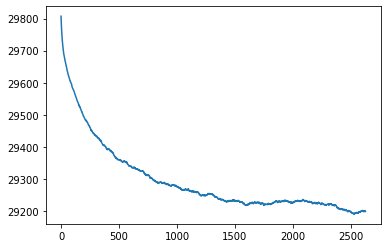

In [18]:
# display the loss
# smoothed losses
smoothed_losses = []
for i in range(0, len(losses)):
    smoothed_losses.append(sum(losses[i:i+500]) / 500)

plt.plot(smoothed_losses[:-500])
# plt.plot(losses)

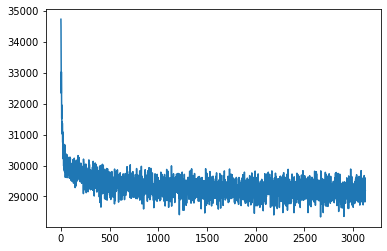

In [19]:
plt.plot(losses)

In [69]:
# save model weights
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}, "checkpoint.pt")

In [50]:
# generate text
sequence_length = 128
@torch.no_grad()
def generate_text(model, start_text: str, length: int) -> str:
    # encode the start text
    encoded_text = torch.tensor([encoder[letter] for letter in list(start_text)], dtype=torch.long)
    # generate the text
    for i in range(length):
        # get the next letter
        text = encoded_text[-sequence_length:]
        y_hat = model(text.unsqueeze(0))
        y_hat = y_hat.squeeze()[:, -1]
        y_hat = F.softmax(y_hat, dim=-1)
        # sample from the distribution
        next_letter = torch.multinomial(y_hat, 1)
        # add the letter to the encoded text
        encoded_text = torch.cat((encoded_text, next_letter))
    # decode the text
    decoded_text = "".join([decoder[letter.item()] for letter in encoded_text])
    return decoded_text

In [ ]:
# load and test model
# model = WaveNet(sequence_length).to("mps")
# model.load_state_dict(torch.load("wavenet_seqlength128.pth", map_location="mps"))
new_model = model.eval().cpu()

# start text of length 128 characters
start_text = " " * 128
# generate text
generated_text = generate_text(new_model, start_text, 2000)
print(generated_text)